In [1]:
#cell 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from scipy import stats
from scipy.stats import shapiro
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [2]:
class DataLoader:
    def __init__(self):
        self.datasets = {}
        self.metadata = {}

    def load_datasets(self):
        files = {
            'combined': 'combined.csv',
            'city_day': 'city_day.csv',
            'city_hour': 'city_hour.csv',
            'station_day': 'station_day.csv',
            'station_hour': 'station_hour.csv',
            'stations': 'stations.csv',
            'cpcb': 'cpcb.csv'
        }

        print("DATA LOADING")
        
        for name, file in files.items():
            df = pd.read_csv(file)
            self.datasets[name] = df
            self.metadata[name] = {
                'shape': df.shape,
                'memory_usage': df.memory_usage(deep=True).sum(),
                'missing_percentage': (df.isnull().sum() / len(df) * 100).round(2)
            }
            print(f"{name:15} | Rows: {df.shape[0]:>7,} | Columns: {df.shape[1]:>3} | Missing: {df.isnull().sum().sum():>6,}")

        return self.datasets, self.metadata

    def report(self):
        report = {}
        for name, df in self.datasets.items():
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            report[name] = {
                'completeness': (1 - df.isnull().sum() / len(df)).mean(),
                'uniqueness': df.nunique().sum() / (df.shape[0] * df.shape[1]),
                'numeric_ratio': len(numeric_cols) / df.shape[1] if df.shape[1] > 0 else 0
            }
        return pd.DataFrame(report).T



In [3]:
class Preprocessor:
    def __init__(self):
        self.outlier_stats = {}

    def detect_outliers(self, df, columns=None):
        if columns is None:
            columns = df.select_dtypes(include=[np.number]).columns

        if len(columns) == 0:
            return pd.DataFrame()

        outlier_methods = {}

        for col in columns:
            if col in df.columns:
                data = df[col].dropna()
                if len(data) == 0:
                    continue

                Q1, Q3 = np.percentile(data, [25, 75])
                IQR = Q3 - Q1
                iqr_outliers = ((data < Q1 - 1.5 * IQR) | (data > Q3 + 1.5 * IQR)).sum()

                if len(data) > 1:
                    z_scores = np.abs(stats.zscore(data))
                    zscore_outliers = (z_scores > 3).sum()
                else:
                    zscore_outliers = 0

                median = np.median(data)
                mad = np.median(np.abs(data - median))
                if mad != 0:
                    modified_z_scores = 0.6745 * (data - median) / mad
                    modified_outliers = (np.abs(modified_z_scores) > 3.5).sum()
                else:
                    modified_outliers = 0

                outlier_methods[col] = {
                    'iqr_outliers': iqr_outliers,
                    'zscore_outliers': zscore_outliers,
                    'modified_zscore_outliers': modified_outliers,
                    'total_points': len(data)
                }

        return pd.DataFrame(outlier_methods).T if outlier_methods else pd.DataFrame()

    def impute_missing_values(self, df):
        df_processed = df.copy()
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        categorical_cols = df.select_dtypes(exclude=[np.number]).columns

        date_cols = ['Date', 'Datetime']
        for col in date_cols:
            if col in df.columns:
                df_processed[col] = pd.to_datetime(df_processed[col], errors='coerce')

        if len(numeric_cols) > 0:
            missing_percentages = df[numeric_cols].isnull().sum() / len(df)

            low_missing = missing_percentages[missing_percentages < 0.1].index
            if len(low_missing) > 0:
                knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
                df_processed[low_missing] = knn_imputer.fit_transform(df_processed[low_missing])

            med_missing = missing_percentages[(missing_percentages >= 0.1) & (missing_percentages < 0.3)].index
            if len(med_missing) > 0:
                iterative_imputer = IterativeImputer(random_state=42)
                df_processed[med_missing] = iterative_imputer.fit_transform(df_processed[med_missing])

            high_missing = missing_percentages[missing_percentages >= 0.3].index
            for col in high_missing:
                if 'AQI' in col.upper():
                    df_processed[col] = df_processed[col].fillna(df_processed[col].median())
                else:
                    df_processed[col] = df_processed[col].fillna(0)

        for col in categorical_cols:
            if col in df_processed.columns:
                mode_val = df_processed[col].mode()
                if len(mode_val) > 0:
                    df_processed[col] = df_processed[col].fillna(mode_val[0])

        return df_processed

    def treat_outliers(self, df, method='winsorize'):
        df_processed = df.copy()
        numeric_cols = df.select_dtypes(include=[np.number]).columns

        for col in numeric_cols:
            if col in df.columns:
                data = df_processed[col]

                if method == 'winsorize':
                    lower, upper = np.percentile(data.dropna(), [1, 99])
                    df_processed[col] = np.clip(data, lower, upper)

        return df_processed



In [4]:
class FeatureEngineer:
    def __init__(self):
        self.feature_importance = {}

    def temporal_features(self, df, date_col):
        if date_col in df.columns:
            df = df.copy()
            df[date_col] = pd.to_datetime(df[date_col])

            df['year'] = df[date_col].dt.year
            df['month'] = df[date_col].dt.month
            df['day'] = df[date_col].dt.day
            df['day_of_week'] = df[date_col].dt.dayofweek
            df['day_of_year'] = df[date_col].dt.dayofyear
            df['week_of_year'] = df[date_col].dt.isocalendar().week
            df['quarter'] = df[date_col].dt.quarter

            df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
            df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
            df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
            df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

            df['season'] = df['month'].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1,
                                         6:2, 7:2, 8:2, 9:3, 10:3, 11:3})
            df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

        return df

    def pollution_features(self, df):
        df = df.copy()
        pollutant_cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']
        available_pollutants = [col for col in pollutant_cols if col in df.columns]

        if len(available_pollutants) >= 2:
            if 'PM2.5' in df.columns and 'PM10' in df.columns:
                df['PM_ratio'] = df['PM2.5'] / (df['PM10'] + 1e-8)

            if 'NO2' in df.columns and 'NO' in df.columns:
                df['NOx_efficiency'] = df['NO2'] / (df['NO'] + df['NO2'] + 1e-8)

            if len(available_pollutants) >= 3:
                pca = PCA(n_components=1)
                pollution_load = pca.fit_transform(df[available_pollutants].fillna(0))
                df['pollution_load_pc1'] = pollution_load.flatten()

        return df

    def spatial_features(self, df):
        df = df.copy()

        city_weights = {
            'Delhi': 1.0, 'Mumbai': 0.9, 'Kolkata': 0.8, 'Chennai': 0.7,
            'Bangalore': 0.6, 'Hyderabad': 0.6, 'Ahmedabad': 0.5, 'Pune': 0.5
        }

        if 'City' in df.columns:
            df['city_weight'] = df['City'].map(city_weights).fillna(0.3)
            city_dummies = pd.get_dummies(df['City'], prefix='city')
            df = pd.concat([df, city_dummies], axis=1)

        return df



In [5]:
def clean_data(master_df, target_column='AQI'):
    print("DATA CLEANING AND PREPARATION")
    print(f"Initial shape: {master_df.shape[0]:,} rows x {master_df.shape[1]} columns")
    
    df = master_df.copy()
    
    leakage_columns = ['AQI_category', 'AQI_log', 'AQI_Bucket', 'AQI_Range', 'AQI_Level']
    leakage_found = [col for col in leakage_columns if col in df.columns]
    if leakage_found:
        df = df.drop(columns=leakage_found)
        print(f"Removed leakage features: {', '.join(leakage_found)}")
    
    df_clean = df.dropna(subset=[target_column])
    print(f"Removed {len(df) - len(df_clean):,} rows with missing target")
    
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]
    
    remove_cols = ['Date', 'Datetime', 'City']
    for col in remove_cols:
        if col in X.columns:
            X = X.drop(columns=[col])
    
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    X_numeric = X[numeric_cols]
    
    final_features = []
    removed_features = {'high_missing': [], 'zero_variance': []}
    
    for col in X_numeric.columns:
        missing_pct = X_numeric[col].isnull().sum() / len(X_numeric)
        if missing_pct > 0.6:
            removed_features['high_missing'].append(col)
            continue
        if X_numeric[col].var() < 1e-10:
            removed_features['zero_variance'].append(col)
            continue
        if col != target_column:
            final_features.append(col)
    
    X_final = X_numeric[final_features]
    
    for col in X_final.columns:
        if X_final[col].isnull().sum() > 0:
            X_final[col] = X_final[col].fillna(X_final[col].median())
    
    mask = ~(X_final.isnull().any(axis=1) | y.isnull())
    X_final = X_final[mask]
    y = y[mask]
    
    print(f"Removed {len(removed_features['high_missing'])} features (>60% missing)")
    print(f"Removed {len(removed_features['zero_variance'])} features (zero variance)")
    print(f"\nFinal dataset: {X_final.shape[0]:,} samples x {X_final.shape[1]} features")
    print(f"Target statistics: min={y.min():.2f}, max={y.max():.2f}, mean={y.mean():.2f}, std={y.std():.2f}")
    
    return X_final, y

In [6]:
def detailed_cross_validation(models, X_train, X_train_scaled, y_train, n_folds=5):
    print("\n")
    print("CROSS-VALIDATION ANALYSIS (K=5)")
    
    scale_required = ['SVR', 'Ridge_Regression']
    cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    all_fold_results = {}
    trained_models = {}
    
    for name, model in models.items():
        print(f"MODEL: {name}")
        X_cv = X_train_scaled if name in scale_required else X_train
        
        fold_results = []
        fold_num = 1
        
        print(f"\nINDIVIDUAL FOLD RESULTS FOR {name}:")
        
        for train_idx, val_idx in cv.split(X_cv):
            X_fold_train, X_fold_val = X_cv.iloc[train_idx], X_cv.iloc[val_idx]
            y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            model_fold = type(model)(**model.get_params())
            model_fold.fit(X_fold_train, y_fold_train)
            y_pred = model_fold.predict(X_fold_val)
            
            r2 = r2_score(y_fold_val, y_pred)
            rmse = np.sqrt(mean_squared_error(y_fold_val, y_pred))
            mae = mean_absolute_error(y_fold_val, y_pred)
            mape = mean_absolute_percentage_error(y_fold_val, y_pred) * 100
            
            fold_results.append({
                'Fold': fold_num,
                'R2': r2,
                'RMSE': rmse,
                'MAE': mae,
                'MAPE': mape,
                'Train_Size': len(train_idx),
                'Val_Size': len(val_idx)
            })
            
            print(f"\nFOLD {fold_num} RESULTS:")
            print("-"*80)
            print(f"{'Metric':<20} {'Value':<15}")
            print("-"*80)
            print(f"{'R2 Score':<20} {r2:<15.4f}")
            print(f"{'RMSE':<20} {rmse:<15.2f}")
            print(f"{'MAE':<20} {mae:<15.2f}")
            print(f"{'MAPE (%)':<20} {mape:<15.2f}")
            print(f"{'Training Samples':<20} {len(train_idx):<15}")
            print(f"{'Validation Samples':<20} {len(val_idx):<15}")
            print("-"*80)
            
            fold_num += 1

        fold_df = pd.DataFrame(fold_results)
        
        print(f"\nSUMMARY STATISTICS FOR {name}:")
        print("="*80)
        print(f"{'Metric':<20} {'Mean':<15} {'Std Dev':<15} {'Min':<15} {'Max':<15}")
        print("-"*80)
        print(f"{'R2 Score':<20} {fold_df['R2'].mean():<15.4f} {fold_df['R2'].std():<15.4f} {fold_df['R2'].min():<15.4f} {fold_df['R2'].max():<15.4f}")
        print(f"{'RMSE':<20} {fold_df['RMSE'].mean():<15.2f} {fold_df['RMSE'].std():<15.2f} {fold_df['RMSE'].min():<15.2f} {fold_df['RMSE'].max():<15.2f}")
        print(f"{'MAE':<20} {fold_df['MAE'].mean():<15.2f} {fold_df['MAE'].std():<15.2f} {fold_df['MAE'].min():<15.2f} {fold_df['MAE'].max():<15.2f}")
        print(f"{'MAPE (%)':<20} {fold_df['MAPE'].mean():<15.2f} {fold_df['MAPE'].std():<15.2f} {fold_df['MAPE'].min():<15.2f} {fold_df['MAPE'].max():<15.2f}")
        print("="*80)
        
        all_fold_results[name] = fold_df
        
        model.fit(X_cv, y_train)
        trained_models[name] = model
    
    return trained_models, all_fold_results



In [7]:
def evaluate_models_detailed(trained_models, X_test, X_test_scaled, y_test, fold_results):  
    print("\n")
    print("MODEL EVALUATION")
    
    scale_required = ['SVR', 'Ridge_Regression']
    results = {}
    
    for name, model in trained_models.items():
        try:
            X_test_model = X_test_scaled if name in scale_required else X_test
            y_pred = model.predict(X_test_model)
            
            if np.any(np.isnan(y_pred)) or np.any(np.isinf(y_pred)):
                continue
            
            r2 = r2_score(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            mape = mean_absolute_percentage_error(y_test, y_pred) * 100
            
            n_samples = len(y_test)
            n_features = X_test.shape[1]
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)
            
            cv_r2_mean = fold_results[name]['R2'].mean()
            cv_r2_std = fold_results[name]['R2'].std()
            cv_rmse_mean = fold_results[name]['RMSE'].mean()
            
            results[name] = {
                'R2': r2,
                'Adj_R2': adj_r2,
                'RMSE': rmse,
                'MAE': mae,
                'MAPE': mape,
                'CV_R2_Mean': cv_r2_mean,
                'CV_R2_Std': cv_r2_std,
                'CV_RMSE_Mean': cv_rmse_mean
            }
            
        except Exception as e:
            print(f"Error evaluating {name}: {str(e)}")
            continue
    
    return results



In [8]:
def print_final_results_table(final_results):  
    print("\n")
    print("COMPREHENSIVE MODEL PERFORMANCE TABLE")
    print(f"{'Model':<20} {'R2':<10} {'Adj_R2':<10} {'RMSE':<10} {'MAE':<10} {'MAPE(%)':<10} {'CV_R2':<15}")
    print("-"*80)
    
    for model, row in final_results.iterrows():
        cv_str = f"{row['CV_R2_Mean']:.4f}±{row['CV_R2_Std']:.3f}"
        print(f"{model:<20} {row['R2']:<10.4f} {row['Adj_R2']:<10.4f} {row['RMSE']:<10.2f} {row['MAE']:<10.2f} {row['MAPE']:<10.2f} {cv_str:<15}")
    
    print("="*80)



In [9]:
def create_visualizations(final_results, trained_models, X_test, X_test_scaled, y_test, best_model_name):
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    models = final_results.index
    colors = plt.cm.Set2(np.linspace(0, 1, len(models)))
    
    ax1 = fig.add_subplot(gs[0, 0])
    r2_scores = final_results['R2']
    bars = ax1.barh(models, r2_scores, color=colors, edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('R2 Score', fontsize=12, fontweight='bold')
    ax1.set_title('Model Performance (R2 Score)', fontsize=14, fontweight='bold')
    ax1.set_xlim(0, 1)
    for i, (bar, score) in enumerate(zip(bars, r2_scores)):
        ax1.text(score + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{score:.4f}', va='center', fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    ax2 = fig.add_subplot(gs[0, 1])
    rmse_scores = final_results['RMSE']
    bars = ax2.barh(models, rmse_scores, color=colors, edgecolor='black', linewidth=1.5)
    ax2.set_xlabel('RMSE', fontsize=12, fontweight='bold')
    ax2.set_title('Root Mean Square Error', fontsize=14, fontweight='bold')
    for i, (bar, score) in enumerate(zip(bars, rmse_scores)):
        ax2.text(score + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{score:.2f}', va='center', fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    ax3 = fig.add_subplot(gs[0, 2])
    x = np.arange(len(models))
    width = 0.35
    cv_r2 = final_results['CV_R2_Mean']
    test_r2 = final_results['R2']
    
    bars1 = ax3.bar(x - width/2, cv_r2, width, label='CV R2', alpha=0.8, color='steelblue', edgecolor='black')
    bars2 = ax3.bar(x + width/2, test_r2, width, label='Test R2', alpha=0.8, color='coral', edgecolor='black')
    
    ax3.set_ylabel('R2 Score', fontsize=12, fontweight='bold')
    ax3.set_title('Cross-Validation vs Test Performance', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(models, rotation=45, ha='right')
    ax3.legend(fontsize=10)
    ax3.grid(axis='y', alpha=0.3)
    
    ax4 = fig.add_subplot(gs[1, 0])
    scale_required = ['SVR', 'Ridge_Regression']
    X_test_best = X_test_scaled if best_model_name in scale_required else X_test
    best_model = trained_models[best_model_name]
    y_pred_best = best_model.predict(X_test_best)
    
    ax4.scatter(y_test, y_pred_best, alpha=0.5, s=30, color='#2E86AB', edgecolors='black', linewidth=0.5)
    ax4.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
    ax4.set_xlabel('Actual AQI', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Predicted AQI', fontsize=12, fontweight='bold')
    ax4.set_title(f'{best_model_name}: Predicted vs Actual', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    ax5 = fig.add_subplot(gs[1, 1])
    residuals = y_test - y_pred_best
    ax5.scatter(y_pred_best, residuals, alpha=0.5, s=30, color='#A23B72', edgecolors='black', linewidth=0.5)
    ax5.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax5.set_xlabel('Predicted AQI', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Residuals', fontsize=12, fontweight='bold')
    ax5.set_title(f'{best_model_name}: Residual Analysis', fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.hist(residuals, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax6.axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {residuals.mean():.2f}')
    ax6.axvline(residuals.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {residuals.median():.2f}')
    ax6.set_xlabel('Residuals', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax6.set_title('Residual Distribution', fontsize=14, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    ax7 = fig.add_subplot(gs[2, :])
    
    metrics_for_heatmap = ['R2', 'Adj_R2', 'RMSE', 'MAE', 'MAPE']
    heatmap_data = final_results[metrics_for_heatmap].T
    
    heatmap_normalized = heatmap_data.copy()
    for idx in heatmap_normalized.index:
        if idx in ['R2', 'Adj_R2']:
            min_val = heatmap_data.loc[idx].min()
            max_val = heatmap_data.loc[idx].max()
            heatmap_normalized.loc[idx] = (heatmap_data.loc[idx] - min_val) / (max_val - min_val + 1e-10)
        else:
            min_val = heatmap_data.loc[idx].min()
            max_val = heatmap_data.loc[idx].max()
            heatmap_normalized.loc[idx] = 1 - ((heatmap_data.loc[idx] - min_val) / (max_val - min_val + 1e-10))
    
    im = ax7.imshow(heatmap_normalized.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    
    ax7.set_xticks(range(len(models)))
    ax7.set_xticklabels(models, rotation=45, ha='right', fontsize=11)
    ax7.set_yticks(range(len(metrics_for_heatmap)))
    ax7.set_yticklabels(metrics_for_heatmap, fontsize=11)
    ax7.set_title('Model Performance Heatmap\n(Green = Better, Red = Worse)', 
                  fontsize=14, fontweight='bold', pad=20)
    
    for i in range(len(metrics_for_heatmap)):
        for j in range(len(models)):
            value = heatmap_data.iloc[i, j]
            if metrics_for_heatmap[i] in ['R2', 'Adj_R2']:
                text = f'{value:.4f}'
            else:
                text = f'{value:.2f}'
            
            text_color = 'white' if heatmap_normalized.iloc[i, j] < 0.5 else 'black'
            ax7.text(j, i, text, ha='center', va='center', 
                    color=text_color, fontweight='bold', fontsize=10)
    
    cbar = plt.colorbar(im, ax=ax7, orientation='horizontal', pad=0.1, aspect=30)
    cbar.set_label('Normalized Performance Score', fontsize=11, fontweight='bold')
    
    plt.suptitle('Comprehensive AQI Prediction Model Analysis', 
                fontsize=18, fontweight='bold', y=0.995)
    plt.show()
    
    return y_pred_best



In [10]:
def generate_research_summary(final_results, X, y, fold_results):
    print(f"\nDATASET CHARACTERISTICS")
    print(f"Total samples:           {len(X):>10,}")
    print(f"Number of features:      {X.shape[1]:>10}")
    print(f"Train/Test split:        {75:>10}% / {25}%")
    print(f"AQI range:               {y.min():>10.1f} - {y.max():.1f}")
    print(f"AQI mean +/- std:        {y.mean():>10.2f} +/- {y.std():.2f}")
    print(f"AQI median:              {y.median():>10.2f}")
    print(f"AQI IQR:                 {np.percentile(y, 75) - np.percentile(y, 25):>10.2f}")
    
    best_model = final_results.index[0]
    best_metrics = final_results.iloc[0]
    
    print(f"\nBEST MODEL: {best_model}")
    print("-" * 80)
    print(f"Test Set Performance:")
    print(f"  R2 Score:              {best_metrics['R2']:.4f}")
    print(f"  Adjusted R2:           {best_metrics['Adj_R2']:.4f}")
    print(f"  RMSE:                  {best_metrics['RMSE']:.2f}")
    print(f"  MAE:                   {best_metrics['MAE']:.2f}")
    print(f"  MAPE:                  {best_metrics['MAPE']:.2f}%")
    
    print(f"\nCross-Validation Performance:")
    print(f"  CV R2:                 {best_metrics['CV_R2_Mean']:.4f} +/- {best_metrics['CV_R2_Std']:.4f}")
    print(f"  CV RMSE:               {best_metrics['CV_RMSE_Mean']:.2f}")
    
    cv_test_diff = abs(best_metrics['R2'] - best_metrics['CV_R2_Mean'])
    print(f"\nModel Generalization:")
    print(f"  Test-CV R2 difference: {cv_test_diff:.4f}")
    
    if cv_test_diff < 0.03:
        print(f"  Status:                Excellent generalization (diff < 0.03)")
    elif cv_test_diff < 0.05:
        print(f"  Status:                Good generalization (diff < 0.05)")
    else:
        print(f"  Status:                Potential overfitting (diff > 0.05)")
    
    r2_values = final_results['R2'].values
    print(f"\nPERFORMANCE DISTRIBUTION ACROSS MODELS")
    print("-" * 80)
    print(f"Best R2:                 {r2_values.max():.4f}")
    print(f"Worst R2:                {r2_values.min():.4f}")
    print(f"Average R2:              {r2_values.mean():.4f}")
    print(f"Std. deviation:          {r2_values.std():.4f}")
    print(f"Range:                   {r2_values.max() - r2_values.min():.4f}")
    
    print(f"\nMODEL STABILITY ANALYSIS")
    print("-" * 80)
    print(f"{'Model':<20} {'CV R2 Range':<20} {'Std Dev':<12} {'Stability':<15}")
    print("-" * 80)
    
    for model in final_results.index:
        if model in fold_results:
            fold_r2 = fold_results[model]['R2']
            min_r2 = fold_r2.min()
            max_r2 = fold_r2.max()
            std_r2 = fold_r2.std()
            
            if std_r2 < 0.02:
                stability = "Very Stable"
            elif std_r2 < 0.05:
                stability = "Stable"
            else:
                stability = "Variable"
            
            print(f"{model:<20} {min_r2:.4f} - {max_r2:.4f}    {std_r2:<12.4f} {stability:<15}")

In [11]:
class EDAAnalyzer:
    def __init__(self, df):
        self.df = df
        self.numeric_cols = df.select_dtypes(include=[np.number]).columns

    def distribution_analysis(self):
        """Analyze distributions of numeric features with statistical tests"""
        n_cols = min(6, len(self.numeric_cols))
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        axes = axes.ravel()

        for i, col in enumerate(self.numeric_cols[:n_cols]):
            data = self.df[col].dropna()
            
            axes[i].hist(data, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
            axes[i].axvline(data.mean(), color='red', linestyle='--', 
                          label=f'Mean: {data.mean():.2f}')
            axes[i].axvline(data.median(), color='green', linestyle='--', 
                          label=f'Median: {data.median():.2f}')
            
            sample_data = data.sample(min(5000, len(data))) if len(data) > 5000 else data
            _, shapiro_p = shapiro(sample_data)
            skewness = stats.skew(data)
            kurtosis = stats.kurtosis(data)
            
            axes[i].set_title(f'{col}\nSkew: {skewness:.2f}, Kurt: {kurtosis:.2f}\n'
                            f'Shapiro p: {shapiro_p:.3f}', fontsize=10)
            axes[i].legend(fontsize=8)
            axes[i].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.suptitle('Distribution Analysis with Statistical Tests', 
                    y=1.00, fontsize=16, fontweight='bold')
        plt.show()

    def correlation_heatmap(self):
        """Generate correlation heatmap with high correlation pairs"""
        print("\n" + "="*80)
        print("CORRELATION ANALYSIS")
        print("="*80)
        
        corr_matrix = self.df[self.numeric_cols].corr()
        
        plt.figure(figsize=(16, 13))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                   square=True, fmt='.2f', cbar_kws={"shrink": .8}, 
                   annot_kws={'size': 8})
        plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        # Identify high correlation pairs
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if abs(corr_matrix.iloc[i, j]) > 0.8:
                    high_corr_pairs.append((
                        corr_matrix.columns[i],
                        corr_matrix.columns[j],
                        corr_matrix.iloc[i, j]
                    ))
        
        if high_corr_pairs:
            print("\nHigh Correlation Pairs (|r| > 0.8):")
            print("-"*80)
            for idx, pair in enumerate(high_corr_pairs[:15], 1):
                print(f"{idx:2d}. {pair[0]:<25} - {pair[1]:<25}: {pair[2]:>6.3f}")
        else:
            print("\nNo high correlation pairs found (|r| > 0.8)")
        
        return corr_matrix


In [12]:
class DimensionalityReducer:
    def __init__(self, df):
        self.df = df
        self.numeric_df = df.select_dtypes(include=[np.number]).dropna()
        self.scaler = RobustScaler()

    def pca_analysis(self, n_features_to_show=15):
        """Perform PCA analysis with visualizations"""
        print("\n" + "="*80)
        print("PRINCIPAL COMPONENT ANALYSIS (PCA)")
        print("="*80)
        
        X_scaled = self.scaler.fit_transform(self.numeric_df)
        
        pca_full = PCA()
        X_pca_full = pca_full.fit_transform(X_scaled)
        
        cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
        n_components_95 = np.argmax(cumsum_var >= 0.95) + 1
        n_components_99 = np.argmax(cumsum_var >= 0.99) + 1
        
        print(f"\nComponents needed for 95% variance: {n_components_95}")
        print(f"Components needed for 99% variance: {n_components_99}")
        print(f"Total features in dataset: {len(self.numeric_df.columns)}")
        print(f"Dimensionality reduction: {len(self.numeric_df.columns)} -> {n_components_95} "
              f"({(1 - n_components_95/len(self.numeric_df.columns))*100:.1f}% reduction)")
        
        fig = plt.figure(figsize=(20, 12))
        gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
        
        # 1. Scree Plot
        ax1 = fig.add_subplot(gs[0, 0])
        n_show = min(20, len(pca_full.explained_variance_ratio_))
        ax1.plot(range(1, n_show + 1), 
                pca_full.explained_variance_ratio_[:n_show], 
                'bo-', linewidth=2, markersize=8)
        ax1.axvline(n_components_95, color='red', linestyle='--', linewidth=2,
                   label=f'95% variance: PC{n_components_95}')
        ax1.set_title('Scree Plot', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Principal Component', fontsize=12)
        ax1.set_ylabel('Explained Variance Ratio', fontsize=12)
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.plot(range(1, len(cumsum_var) + 1), cumsum_var, 'ro-', 
                linewidth=2, markersize=6)
        ax2.axhline(0.95, color='green', linestyle='--', linewidth=2, 
                   label='95% threshold')
        ax2.axhline(0.99, color='blue', linestyle='--', linewidth=2, 
                   label='99% threshold')
        ax2.axvline(n_components_95, color='red', linestyle='--', linewidth=2)
        ax2.set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Number of Components', fontsize=12)
        ax2.set_ylabel('Cumulative Variance', fontsize=12)
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        ax3 = fig.add_subplot(gs[0, 2])
        eigenvalues = pca_full.explained_variance_[:n_show]
        ax3.bar(range(1, n_show + 1), eigenvalues, color='skyblue', 
               edgecolor='black', linewidth=1.5)
        ax3.axhline(1, color='red', linestyle='--', linewidth=2, 
                   label='Kaiser Criterion (λ=1)')
        ax3.set_title('Eigenvalues by Component', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Principal Component', fontsize=12)
        ax3.set_ylabel('Eigenvalue', fontsize=12)
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
        
        ax4 = fig.add_subplot(gs[1, 0])
        feature_names = self.numeric_df.columns
        pc1_contributions = pca_full.components_[0]
        top_indices = np.argsort(np.abs(pc1_contributions))[-n_features_to_show:]
        
        colors_pc1 = ['red' if x < 0 else 'green' for x in pc1_contributions[top_indices]]
        ax4.barh(range(n_features_to_show), pc1_contributions[top_indices], 
                color=colors_pc1, edgecolor='black', linewidth=1)
        ax4.set_yticks(range(n_features_to_show))
        ax4.set_yticklabels([feature_names[i] for i in top_indices], fontsize=9)
        ax4.set_title(f'PC1 Top {n_features_to_show} Features\n'
                     f'(Explains {pca_full.explained_variance_ratio_[0]*100:.1f}% variance)',
                     fontsize=12, fontweight='bold')
        ax4.set_xlabel('Contribution', fontsize=11)
        ax4.grid(True, alpha=0.3, axis='x')
        
        ax5 = fig.add_subplot(gs[1, 1])
        pc2_contributions = pca_full.components_[1]
        top_indices_pc2 = np.argsort(np.abs(pc2_contributions))[-n_features_to_show:]
        
        colors_pc2 = ['red' if x < 0 else 'green' for x in pc2_contributions[top_indices_pc2]]
        ax5.barh(range(n_features_to_show), pc2_contributions[top_indices_pc2], 
                color=colors_pc2, edgecolor='black', linewidth=1)
        ax5.set_yticks(range(n_features_to_show))
        ax5.set_yticklabels([feature_names[i] for i in top_indices_pc2], fontsize=9)
        ax5.set_title(f'PC2 Top {n_features_to_show} Features\n'
                     f'(Explains {pca_full.explained_variance_ratio_[1]*100:.1f}% variance)',
                     fontsize=12, fontweight='bold')
        ax5.set_xlabel('Contribution', fontsize=11)
        ax5.grid(True, alpha=0.3, axis='x')
        
        ax6 = fig.add_subplot(gs[1, 2])
        sample_indices = np.random.choice(len(X_pca_full), 
                                         size=min(1000, len(X_pca_full)), 
                                         replace=False)
        scatter = ax6.scatter(X_pca_full[sample_indices, 0], 
                            X_pca_full[sample_indices, 1],
                            alpha=0.3, s=20, c='steelblue', edgecolors='none')
        ax6.set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]*100:.1f}%)', 
                      fontsize=11)
        ax6.set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]*100:.1f}%)', 
                      fontsize=11)
        ax6.set_title('PCA Biplot (PC1 vs PC2)', fontsize=12, fontweight='bold')
        ax6.grid(True, alpha=0.3)
        ax6.axhline(0, color='black', linewidth=0.5)
        ax6.axvline(0, color='black', linewidth=0.5)
        
        plt.suptitle('Principal Component Analysis - Comprehensive View', 
                    fontsize=18, fontweight='bold', y=0.995)
        plt.show()
        
        print("\n" + "-"*80)
        print("TOP 5 PRINCIPAL COMPONENTS SUMMARY")
        print("-"*80)
        print(f"{'PC':<5} {'Variance %':<15} {'Cumulative %':<15} {'Eigenvalue':<15}")
        print("-"*80)
        for i in range(min(5, len(pca_full.explained_variance_ratio_))):
            print(f"PC{i+1:<3} {pca_full.explained_variance_ratio_[i]*100:<15.2f} "
                  f"{cumsum_var[i]*100:<15.2f} {pca_full.explained_variance_[i]:<15.2f}")
        print("="*80)
        
        return n_components_95, pca_full



DATA LOADING
combined        | Rows:   7,659 | Columns:   7 | Missing:  1,460
city_day        | Rows:  29,531 | Columns:  16 | Missing: 88,488
city_hour       | Rows: 707,875 | Columns:  16 | Missing: 2,515,685
station_day     | Rows: 108,035 | Columns:  16 | Missing: 422,673
station_hour    | Rows: 2,589,083 | Columns:  16 | Missing: 11,664,492
stations        | Rows:     230 | Columns:   5 | Missing:     97
cpcb            | Rows:   3,078 | Columns:  11 | Missing:    858
PREPROCESSING
Complete
Complete
Complete
Complete
Complete
Complete
Complete


FEATURE ENGINEERING
Temporal features added
Pollution features added
Spatial features added


EXPLORATORY DATA ANALYSIS


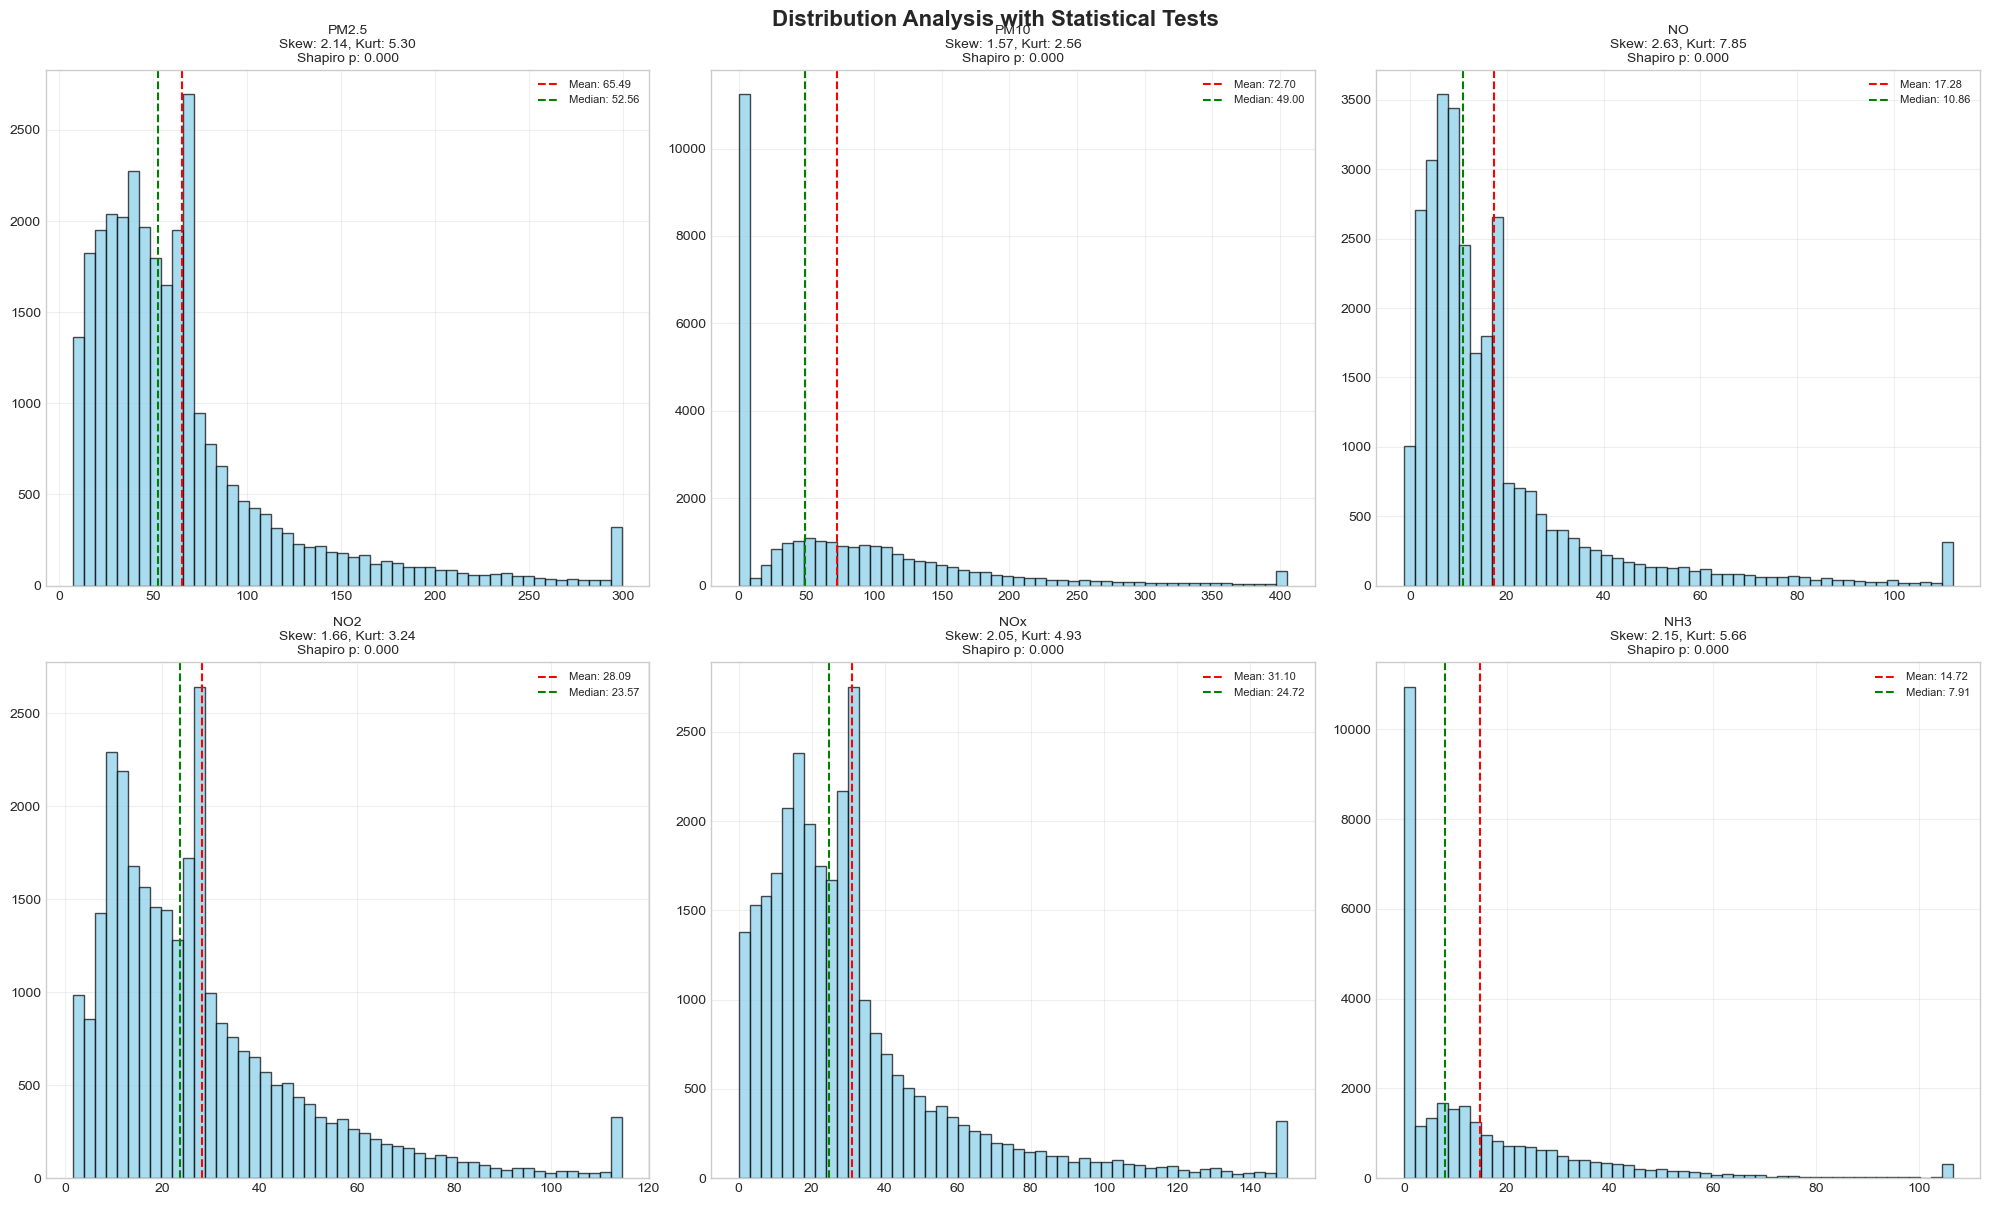


CORRELATION ANALYSIS


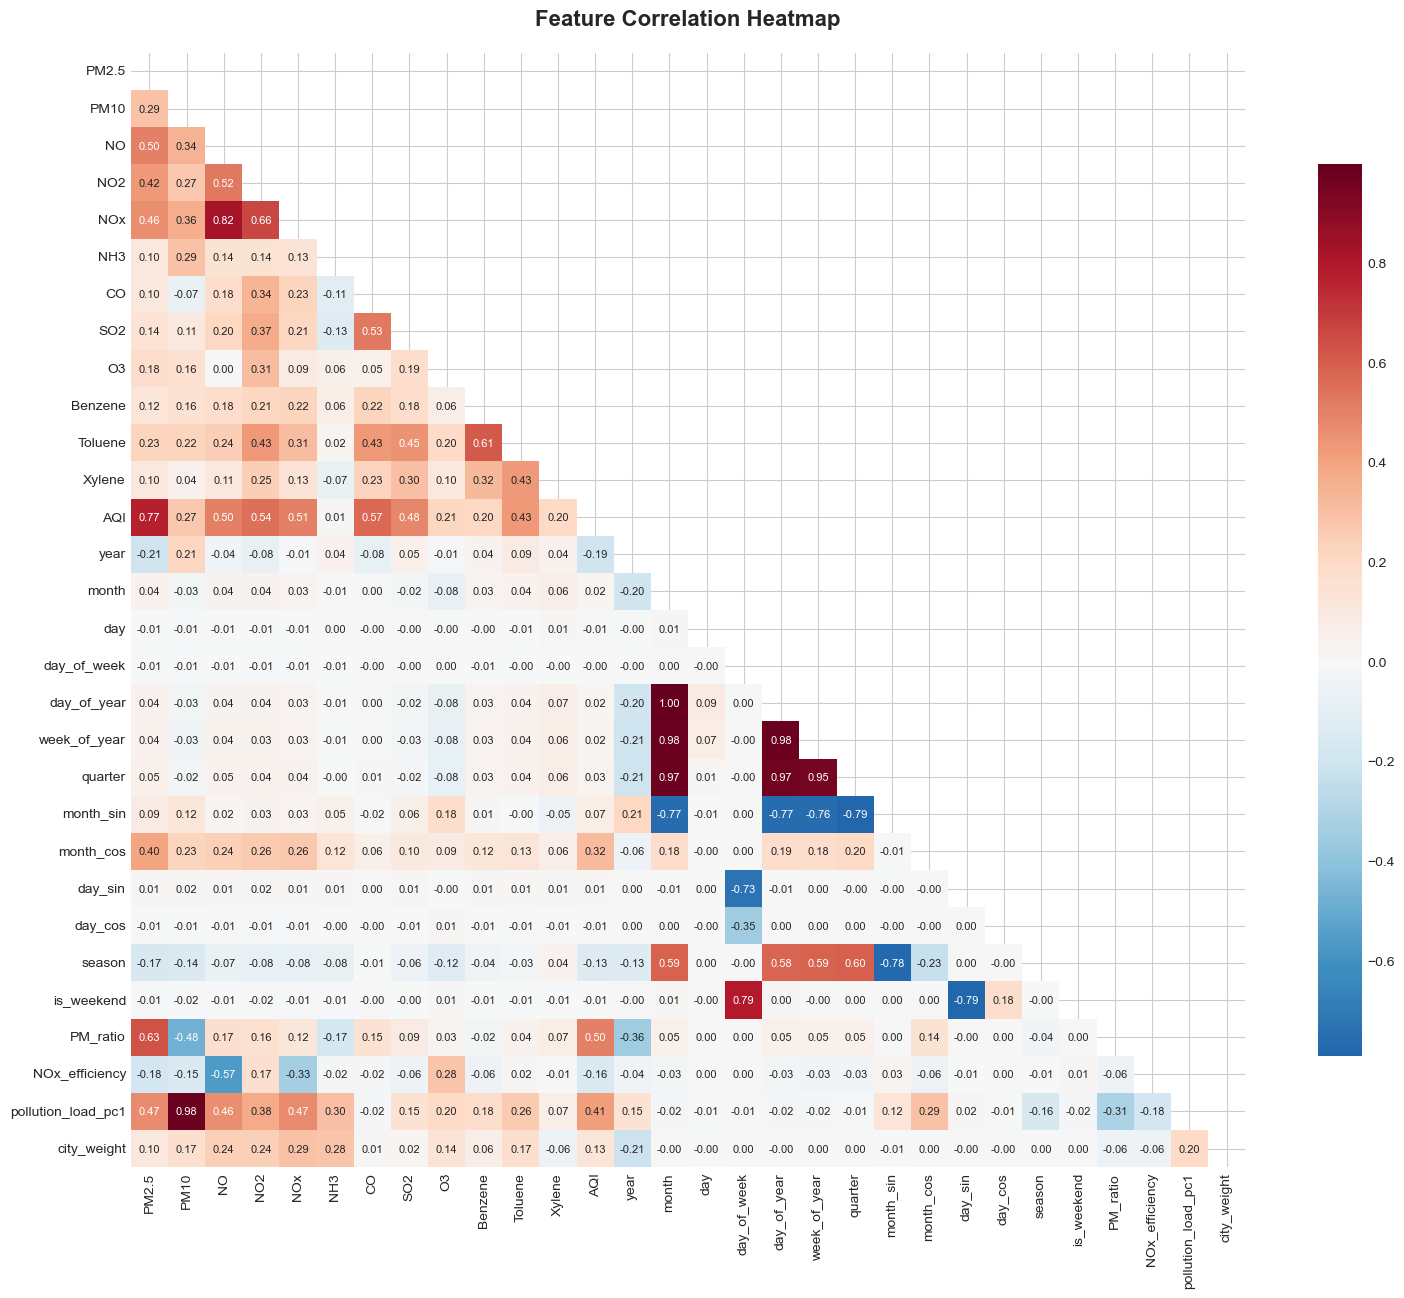


High Correlation Pairs (|r| > 0.8):
--------------------------------------------------------------------------------
 1. PM10                      - pollution_load_pc1       :  0.980
 2. NO                        - NOx                      :  0.822
 3. month                     - day_of_year              :  0.996
 4. month                     - week_of_year             :  0.977
 5. month                     - quarter                  :  0.971
 6. day_of_year               - week_of_year             :  0.979
 7. day_of_year               - quarter                  :  0.968
 8. week_of_year              - quarter                  :  0.951


DIMENSIONALITY REDUCTION PCA

PRINCIPAL COMPONENT ANALYSIS (PCA)

Components needed for 95% variance: 11
Components needed for 99% variance: 18
Total features in dataset: 30
Dimensionality reduction: 30 -> 11 (63.3% reduction)


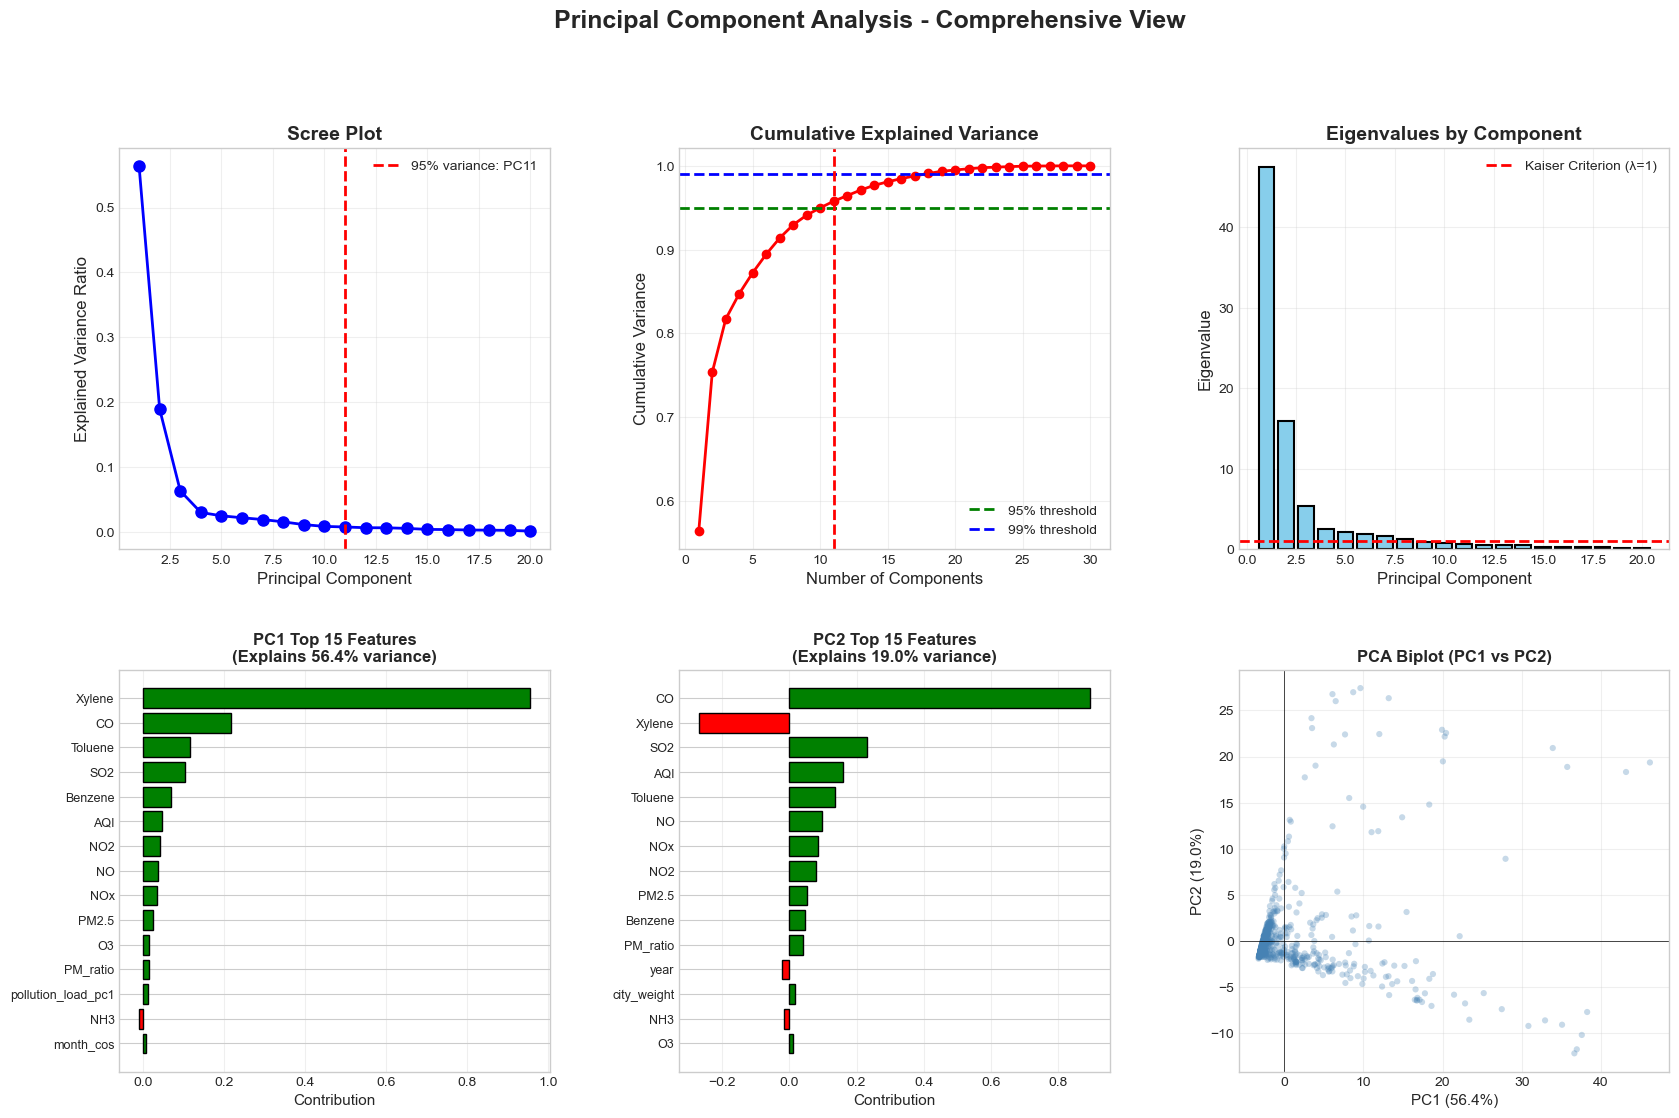


--------------------------------------------------------------------------------
TOP 5 PRINCIPAL COMPONENTS SUMMARY
--------------------------------------------------------------------------------
PC    Variance %      Cumulative %    Eigenvalue     
--------------------------------------------------------------------------------
PC1   56.43           56.43           47.52          
PC2   18.95           75.38           15.96          
PC3   6.36            81.73           5.35           
PC4   3.02            84.76           2.55           
PC5   2.50            87.26           2.11           

PCA Analysis Complete: 11
DATA CLEANING AND PREPARATION
Initial shape: 29,531 rows x 59 columns
Removed leakage features: AQI_Bucket
Removed 0 rows with missing target
Removed 0 features (>60% missing)
Removed 0 features (zero variance)

Final dataset: 29,531 samples x 29 features
Target statistics: min=34.00, max=626.40, mean=162.28, std=113.34

Train set: 22,148 samples
Test set: 7,383 sampl

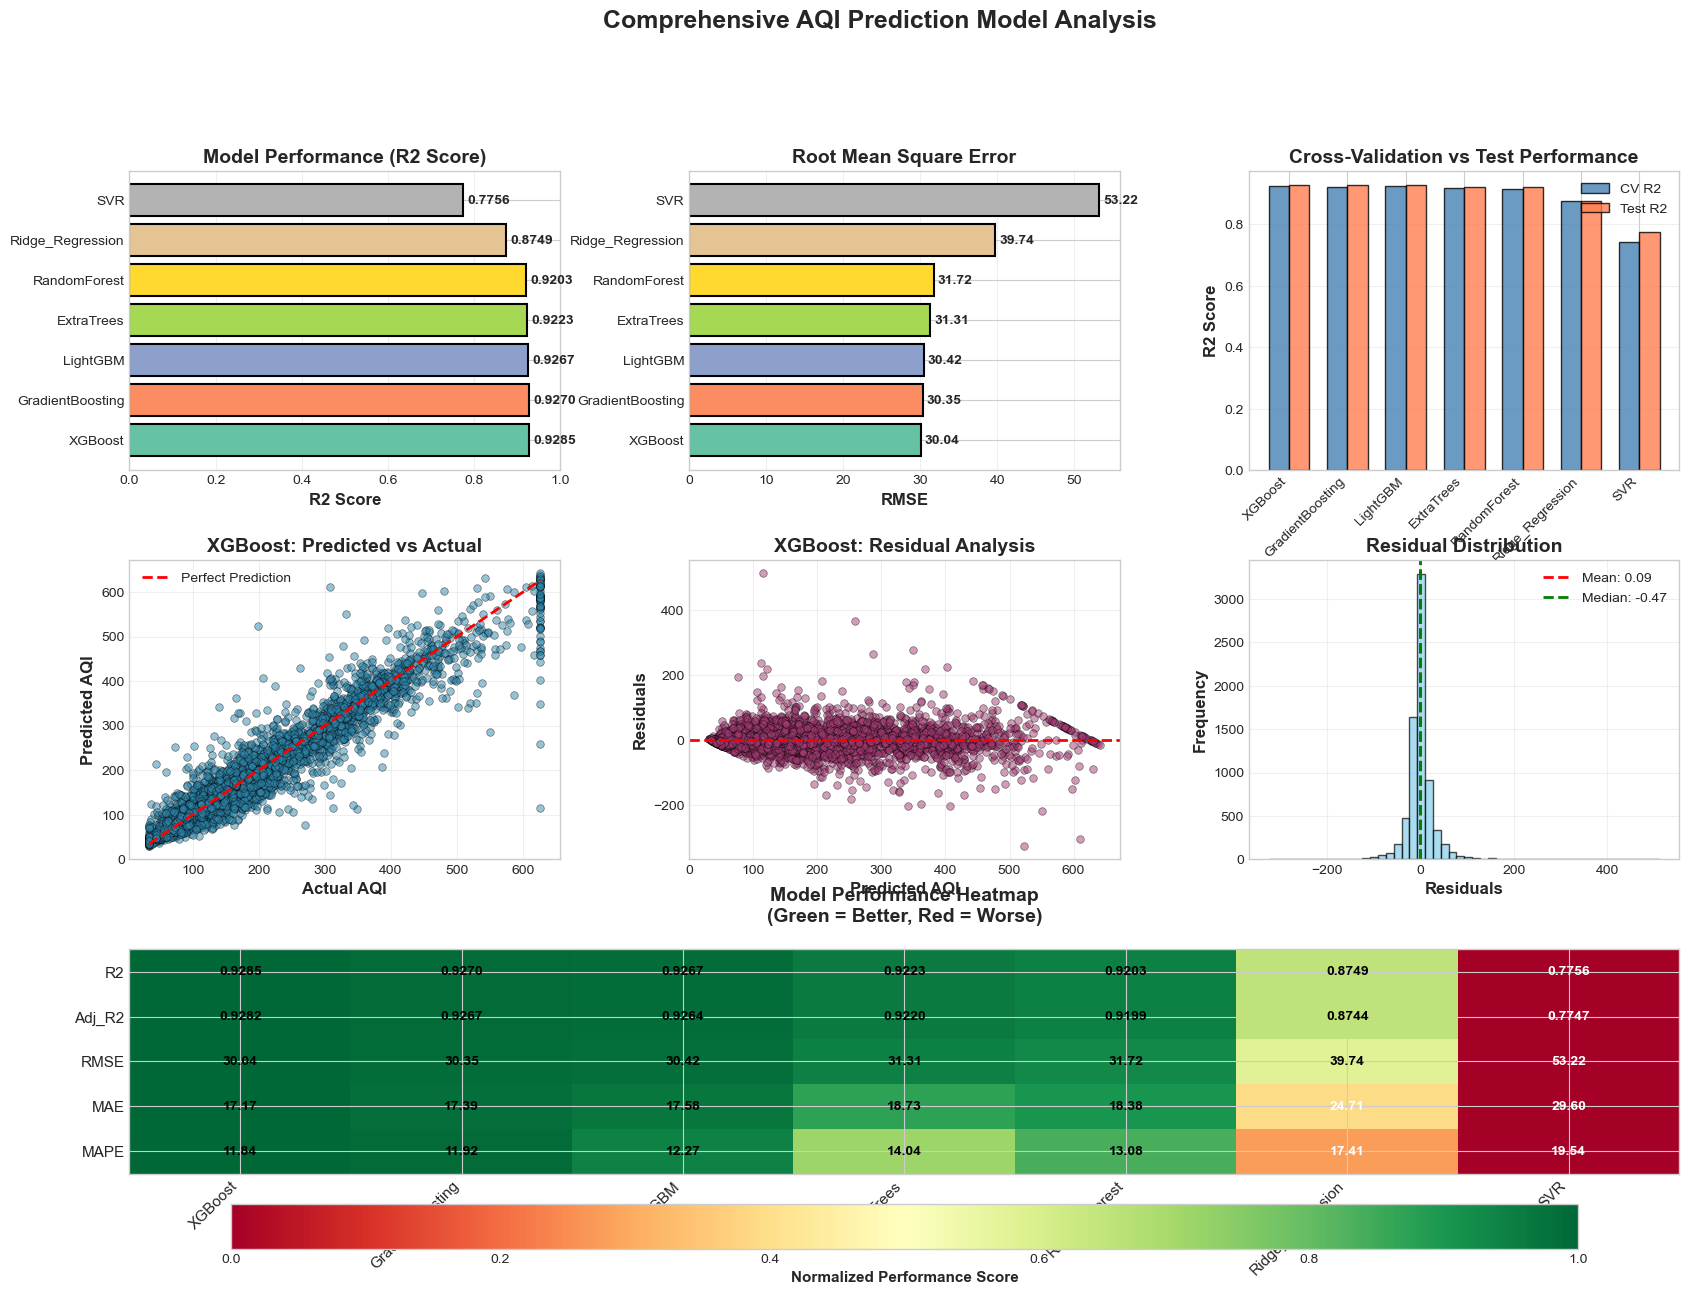


DATASET CHARACTERISTICS
Total samples:               29,531
Number of features:              29
Train/Test split:                75% / 25%
AQI range:                     34.0 - 626.4
AQI mean +/- std:            162.28 +/- 113.34
AQI median:                  126.09
AQI IQR:                     106.00

BEST MODEL: XGBoost
--------------------------------------------------------------------------------
Test Set Performance:
  R2 Score:              0.9285
  Adjusted R2:           0.9282
  RMSE:                  30.04
  MAE:                   17.17
  MAPE:                  11.84%

Cross-Validation Performance:
  CV R2:                 0.9247 +/- 0.0082
  CV RMSE:               31.14

Model Generalization:
  Test-CV R2 difference: 0.0038
  Status:                Excellent generalization (diff < 0.03)

PERFORMANCE DISTRIBUTION ACROSS MODELS
--------------------------------------------------------------------------------
Best R2:                 0.9285
Worst R2:                0.7756
Averag

In [13]:
if __name__ == "__main__":
    loader = DataLoader()
    datasets, metadata = loader.load_datasets()
    quality_report = loader.report()

    print("PREPROCESSING")
    preprocessor = Preprocessor()
    processed_datasets = {}
    
    for name, df in datasets.items():
        df_imputed = preprocessor.impute_missing_values(df)
        df_final = preprocessor.treat_outliers(df_imputed, method='winsorize')
        processed_datasets[name] = df_final
        print(f"Complete")
    
    if 'city_day' in processed_datasets:
        print("\n")
        print("FEATURE ENGINEERING")
        
        feature_engineer = FeatureEngineer()
        master_df = processed_datasets['city_day'].copy()
        
        master_df = feature_engineer.temporal_features(master_df, 'Date')
        print(f"Temporal features added")
        
        master_df = feature_engineer.pollution_features(master_df)
        print("Pollution features added")
        
        master_df = feature_engineer.spatial_features(master_df)
        print("Spatial features added")
        
    print("\n")
    print("EXPLORATORY DATA ANALYSIS")
    
    eda = EDAAnalyzer(master_df)
    eda.distribution_analysis()
    corr_matrix = eda.correlation_heatmap()
    
    print("\n")
    print("DIMENSIONALITY REDUCTION PCA")
    
    dim_reducer = DimensionalityReducer(master_df)
    optimal_components, pca_model = dim_reducer.pca_analysis()
    print(f"\nPCA Analysis Complete: {optimal_components}")
    X, y = clean_data(master_df)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, shuffle=True
    )
    
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train), 
        columns=X_train.columns, 
        index=X_train.index
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test), 
        columns=X_test.columns, 
        index=X_test.index
    )
    
    print(f"\nTrain set: {X_train.shape[0]:,} samples")
    print(f"Test set: {X_test.shape[0]:,} samples")
    
    models = {
        'XGBoost': xgb.XGBRegressor(
            n_estimators=150, learning_rate=0.08, max_depth=8,
            subsample=0.8, colsample_bytree=0.8, random_state=42, 
            n_jobs=-1, verbosity=0
        ),
        'LightGBM': lgb.LGBMRegressor(
            n_estimators=150, learning_rate=0.08, max_depth=8,
            num_leaves=50, subsample=0.8, colsample_bytree=0.8,
            random_state=42, n_jobs=-1, verbosity=-1
        ),
        'RandomForest': RandomForestRegressor(
            n_estimators=150, max_depth=12, min_samples_split=5,
            min_samples_leaf=2, random_state=42, n_jobs=-1
        ),
        'GradientBoosting': GradientBoostingRegressor(
            n_estimators=150, learning_rate=0.08, max_depth=8,
            subsample=0.8, random_state=42
        ),
        'ExtraTrees': ExtraTreesRegressor(
            n_estimators=150, max_depth=12, min_samples_split=5,
            min_samples_leaf=2, random_state=42, n_jobs=-1
        ),
        'SVR': SVR(kernel='rbf', C=1.0, gamma='scale', epsilon=0.1),
        'Ridge_Regression': Ridge(alpha=1.0, fit_intercept=True)
    }
    
    print("\n")
    print("MODELS INITIALIZED")
    for name in models.keys():
        print(f"{name}")
    
    trained_models, fold_results = detailed_cross_validation(
        models, X_train, X_train_scaled, y_train, n_folds=5
    )
    
    evaluation_results = evaluate_models_detailed(
        trained_models, X_test, X_test_scaled, y_test, fold_results
    )
    
    final_results = pd.DataFrame(evaluation_results).T
    final_results = final_results.sort_values('R2', ascending=False)
    best_model_name = final_results.index[0]
    
    print_final_results_table(final_results)
    
    predictions = create_visualizations(
        final_results, trained_models, X_test, X_test_scaled, 
        y_test, best_model_name
    )
    generate_research_summary(final_results, X, y, fold_results)
    